# Yandex.Afisha Businesss Analytics Project

In the following project we will help optimize marketing expenses for Yandex.Afisha. 
<br/>
The project will include data from 3 sources:
- Visit logs to Yandex.Afisha (06-2017 to 05-2018).
- Orders within this period.
- Marketing expenses.

The analysis will focus on 3 aspects in Yandex.Afisha:
- Product
- Sales 
- Marketing

Lastly, conclusions will be drawn and translated to marketing advice: how much money to invest and where.

## Data Preprocessing
In this section, we will load the data and get an overview of it. Then, we'll prepare it for our analysis.

### Loading the data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import math
import numpy as np
from matplotlib.ticker import MaxNLocator
from matplotlib.dates import MonthLocator, DateFormatter as dates
import seaborn as sns

We will optimize the data before loading it. This will save us memory and time, and will spare us the process of converting columns to the correct data type.

In [2]:
# Load visit logs dataset

try:
    visits = pd.read_csv('visits_log_us.csv',
                dtype={'Device': 'category'},
                parse_dates=['Start Ts', 'End Ts'])
except:
    visits = pd.read_csv('/datasets/visits_log_us.csv',
                dtype={'Device': 'category'},
                parse_dates=['Start Ts', 'End Ts'])
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
Device       359400 non-null category
End Ts       359400 non-null datetime64[ns]
Source Id    359400 non-null int64
Start Ts     359400 non-null datetime64[ns]
Uid          359400 non-null uint64
dtypes: category(1), datetime64[ns](2), int64(1), uint64(1)
memory usage: 11.3 MB


In [3]:
# Load orders dataset

try:
    orders = pd.read_csv('orders_log_us.csv', parse_dates=['Buy Ts'])
except:
    orders = pd.read_csv('/datasets/orders_log_us.csv', parse_dates=['Buy Ts'])
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
Buy Ts     50415 non-null datetime64[ns]
Revenue    50415 non-null float64
Uid        50415 non-null uint64
dtypes: datetime64[ns](1), float64(1), uint64(1)
memory usage: 1.2 MB


In [4]:
# Load costs dataset

try:
    costs = pd.read_csv('costs_us.csv', parse_dates=['dt'])
except:
    costs = pd.read_csv('/datasets/costs_us.csv', parse_dates=['dt'])
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
source_id    2542 non-null int64
dt           2542 non-null datetime64[ns]
costs        2542 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 59.7 KB


### Column Names

The columns in `visits` and `orders` are capitalized and contain spaces. We will convert them to lower case and replace spaces with an underscore. This will make them more simple to work with.

In [5]:
# Convert `visits` columns to lower case and separated by underscore

visits.columns = visits.columns.str.lower().str.replace(' ', '_')
visits.columns

Index(['device', 'end_ts', 'source_id', 'start_ts', 'uid'], dtype='object')

In [6]:
# Convert `orders` columns to lower case and separated by underscore

orders.columns = orders.columns.str.lower().str.replace(' ', '_')
orders.columns

Index(['buy_ts', 'revenue', 'uid'], dtype='object')

#### Conclusion

All column names are now unified and easier to access.

### Overview
Let's get an overview of the 3 datasets we just loaded. While observing the data, we will also be looking for anomalies.

#### `vists`

In [7]:
visits.info()
visits.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
device       359400 non-null category
end_ts       359400 non-null datetime64[ns]
source_id    359400 non-null int64
start_ts     359400 non-null datetime64[ns]
uid          359400 non-null uint64
dtypes: category(1), datetime64[ns](2), int64(1), uint64(1)
memory usage: 11.3 MB


,device,end_ts,source_id,start_ts,uid
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168


##### Dataset's Time Period

It's important to make sure that the time period of the entries in the dataset matches the description. I will use describe method to see the first and last visits in this log.

In [8]:
visits['start_ts'].describe()

count                  359400
unique                 224303
top       2017-11-24 16:06:00
freq                       19
first     2017-06-01 00:01:00
last      2018-05-31 23:59:00
Name: start_ts, dtype: object

In [9]:
visits['end_ts'].describe()

count                  359400
unique                 224760
top       2017-11-24 16:51:00
freq                       23
first     2017-06-01 00:02:00
last      2018-06-01 01:26:00
Name: end_ts, dtype: object

Some of the sessions end times are exceeding the time limit. But as can be seen below, they belong to sessions started during our time period. This is not a mistake - these entries should be considered part of our time period.

In [10]:
# Further check the last 

visits[visits['end_ts'] == visits['end_ts'].max()]

,device,end_ts,source_id,start_ts,uid
342205,touch,2018-06-01 01:26:00,1,2018-05-31 23:44:00,13670831770959132678


##### Rest of `visits` Columns

In [11]:
visits['device'].unique()

[touch, desktop]
Categories (2, object): [touch, desktop]

In [12]:
visits['source_id'].unique()

array([ 4,  2,  5,  9,  3,  1, 10,  7,  6])

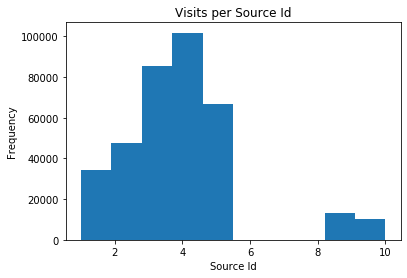

In [13]:
visits['source_id'].plot(kind='hist', title='Visits per Source Id').set_xlabel("Source Id");

##### Conclusion

Nothing unusual in `visits` dataset. Some sessions ended beyond our time period, but we saw that their start time was within the limits.

There are only 2 devices registered ('touch' and 'desktop'), and there are 9 source ids (there are no entries with source id #8), and number of visits from each source varies significantly.

#### `Orders`

In [14]:
orders.info()
orders.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
buy_ts     50415 non-null datetime64[ns]
revenue    50415 non-null float64
uid        50415 non-null uint64
dtypes: datetime64[ns](1), float64(1), uint64(1)
memory usage: 1.2 MB


,buy_ts,revenue,uid
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447
2,2017-06-01 00:27:00,0.37,17903680561304213844
3,2017-06-01 00:29:00,0.55,16109239769442553005
4,2017-06-01 07:58:00,0.37,14200605875248379450


##### `orders['buy_ts']`

In [15]:
orders['buy_ts'].describe()

count                   50415
unique                  45991
top       2018-05-31 10:13:00
freq                        9
first     2017-06-01 00:10:00
last      2018-06-01 00:02:00
Name: buy_ts, dtype: object

##### `orders['revenue']`

The following table shows that 75% of the orders had a revenue of less than 5. The max value is not even near the majority of the data. Also, some orders had a revenue of 0. 

In [16]:
orders['revenue'].describe()

count    50415.000000
mean         4.999647
std         21.818359
min          0.000000
25%          1.220000
50%          2.500000
75%          4.890000
max       2633.280000
Name: revenue, dtype: float64

This is how most of the orders' revenues are distributed. The most common order brings revenue of 1-2.

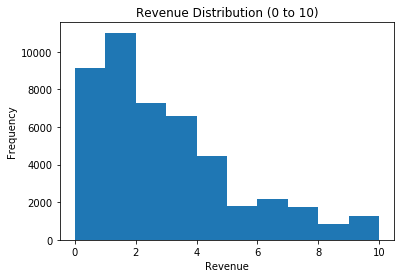

In [17]:
orders['revenue'].plot(kind='hist', title='Revenue Distribution (0 to 10)', range=(0,10)).set_xlabel("Revenue");

###### Zero-Revenue Orders

In [18]:
## calculate the number of zero revenue orders

zero_revenue_orders = orders.query('revenue == 0')['revenue'].count()
zero_revenue_pct = zero_revenue_orders / len(orders)
print(
    "There are {0} orders with zero revenue, which are {1:.2%} of all orders."
    .format(zero_revenue_orders, zero_revenue_pct)
)

There are 51 orders with zero revenue, which are 0.10% of all orders.


In [19]:
## Let's have a look at some of these orders

orders.query('revenue == 0').head()

,buy_ts,revenue,uid
1802,2017-06-22 18:19:00,0.0,17030528792926543083
2787,2017-07-07 15:54:00,0.0,10281425020415612933
4783,2017-08-02 14:54:00,0.0,184148767273119549
5095,2017-08-09 14:48:00,0.0,5603453646174104178
5863,2017-08-23 13:43:00,0.0,5603453646174104178


In [20]:
## Which users order zero revenue orders?

orders.query('revenue == 0')['uid'].value_counts().head()

2037345392173160982    12
5603453646174104178     6
8277558335454815700     6
5570343171257035973     4
4927261749585088199     4
Name: uid, dtype: int64

We can see that 32 out of 51 of the zero-revenue orders were made by the same 5 users. Since the same users have numerous such orders, it seems less likely that this was some kind of a special offer. There are several other explanations. Perhaps it is simply a feature that was given for free for some users or at some time, or maybe these users have a different paying method. Other possible explanation is that the revenue ended up zero because of other related expenses (shipping, for example).

##### High Revenue Orders

In [21]:
## calculate the number of high revenue orders

high_revenue_orders = orders.query('revenue > 1000')['revenue'].count()
high_revenue_pct = high_revenue_orders / len(orders)
print(
    "There are {0} orders with revenue greater than 1000, which are {1:.2%} of all orders."
    .format(high_revenue_orders, high_revenue_pct)
)

There are 7 orders with revenue greater than 1000, which are 0.01% of all orders.


While most of the orders had revenue of less than 5, there are 7 orders that had revenue of over 1000. Let's have a deeper look at these orders.

In [22]:
orders.query('revenue > 1000')

,buy_ts,revenue,uid
23165,2017-12-10 13:04:00,1195.64,5539673724080479777
23244,2017-12-10 20:17:00,2633.28,5539673724080479777
24607,2017-12-17 18:06:00,1109.10,11149926373378902217
36522,2018-02-23 08:54:00,1236.28,11149926373378902217
36682,2018-02-24 09:25:00,1221.37,11149926373378902217
40386,2018-03-18 09:13:00,1073.11,11149926373378902217
47507,2018-05-16 19:53:00,1080.44,11149926373378902217


All orders were made by only 2 users. Let's see how many different users placed orders with revenue greater than 250.

In [23]:
# UID for orders with revenues greater than 250

orders.query('revenue > 250')['uid'].value_counts()

11149926373378902217    12
5539673724080479777     11
17999372575896145244     2
12069004609949546307     1
8539015707073391293      1
16152080406371512880     1
17296569523374666680     1
17956827303229825606     1
255246909617571582       1
Name: uid, dtype: int64

We see the same pattern - most orders above 250 were made by the same two users we saw earlier. Perhaps there are Ids which belong to larger organizations, and not to ordinary users.

##### Conclusions

As observed in this section, the data in `orders` dataset fits the required time period of our analysis. 

Most of the orders in `orders['revenues']` column had revenue smaller than 5. There were also some odd values: Around 0.1% of the orders had zero revenue, most of them ordered by the same 5 user. This could be orders of features given for free, or maybe these users have different paying method. In addition, there were two users which had significantly larger orders - much higher than most of the orders. These could possibly be users that belong to an organization.

#### Costs

In [24]:
costs.info()
costs.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
source_id    2542 non-null int64
dt           2542 non-null datetime64[ns]
costs        2542 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 59.7 KB


,source_id,dt,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25
2,1,2017-06-03,36.53
3,1,2017-06-04,55.00
4,1,2017-06-05,57.08


##### `costs['dt']`
The values in this column fit the required time period for the analysis.

In [25]:
costs['dt'].describe()

count                    2542
unique                    364
top       2018-03-03 00:00:00
freq                        7
first     2017-06-01 00:00:00
last      2018-05-31 00:00:00
Name: dt, dtype: object

##### `costs['source_id']`

We can see that no investment was made in sources 6, 7 and 8. This explains the low performance in visits. The distribution here shows the number of days in which investment was made in each source, and as can be seen, all other sources had expenses for the whole year.

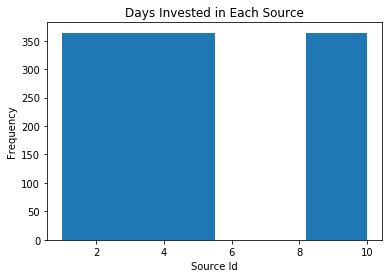

In [26]:
costs['source_id'].plot(kind='hist', title='Days Invested in Each Source').set_xlabel('Source Id');

##### `costs['costs']`

Most of the days, cost did not exceed 250 for a single source. However, there are some days in which expense for a single source was even higher than 1000.

In [27]:
costs['costs'].describe()

count    2542.000000
mean      129.477427
std       156.296628
min         0.540000
25%        21.945000
50%        77.295000
75%       170.065000
max      1788.280000
Name: costs, dtype: float64

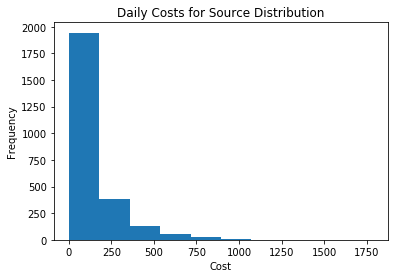

In [28]:
costs['costs'].plot(kind='hist', title='Daily Costs for Source Distribution').set_xlabel('Cost');

##### Conclusion

Data entries fit the time period required for the analysis. It is visibile that no expenses were invested in some sources (6, 7 and 8). Most expenses per source per day were smaller than 250, but few of them were greater than even 1000. 

#### Overview Conclusions

By this quick overview, we made sure that the data fits the dates that are required for our analysis.

The visits are distributed between the sources with source 4 with most visits, while visits from sources 6, 7 and 8 corresponded the investment in them and brought zero or nearly zero visitors.

Most orders had a revenue smaller than 5. 10% of the orders had zero revenue - This could be the result of free features in the platform, different paying methods for some users, or simply that this order had other expenses (shipping, etc). Some other orders, most of them from 2 specific users, had much greater revenues. It could be that these users represent larger organizations.

### Data Preprocessing - Conclusions

All datasets are now loaded and ready for analysis. In this section, we loaded the datasets in the right datatypes for each column. Then, we had a quick overview of the data, during which we made sure that the data fits the required dates of the analysis. We also went over some of the data to find and try to explain anomalies.

We can move on to the next stage.

## Reports and Metrics

In this section, the data will be used to generate reports and calculate business metrics. Based on these metrics, we will derive conclusions and advices to the marketing experts.

The analysis will focus on these 3 aspects of Yandex.Afisha:
- Product
- Sales
- Marketing

Each stage will include an examination of how the mentioned metrics differ for various devices, ad sources and over time.

### Product

In this section, we will address the following questions:
- User Activity - Number of people who use it daily, weekly, monthly.
- Sessions
    - Number of sessions per day.
    - Sessions length.
- Users Retention

#### User Activity

We will calculate the main user activity metrics: DAU, WAU and MAU. Then, the change in these metrics will be examined for different devices, ad sources and over time.

First, new columns in `visits` set should be created. They will specify each rows' date, week, month and year. Then, we will group them and look for unique number of entries for each group.

In [29]:
# Create mentioned columns based on `start_ts` column

visits['session_year'] = visits['start_ts'].dt.year
visits['session_month'] = visits['start_ts'].dt.month
visits['session_week'] = visits['start_ts'].dt.week
visits['session_date'] = visits['start_ts'].dt.date

# Let's see the result...

visits.head()

,device,end_ts,source_id,start_ts,uid,session_year,session_month,session_week,session_date
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017,12,51,2017-12-20
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018,2,8,2018-02-19
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017,7,26,2017-07-01
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018,5,20,2018-05-20
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,2017,12,52,2017-12-27


In [30]:
# Group `visits` data for daily, weekly and monthly visits

daily_visits = visits.groupby('session_date').agg({'uid': 'nunique'}).reset_index()
weekly_visits = visits.groupby(['session_year', 'session_week']).agg({'uid': 'nunique'}).reset_index()
monthly_visits = visits.groupby(['session_year', 'session_month']).agg({'uid': 'nunique'}).reset_index()

##### DAU, WAU and MAU

We will calculate the mean to get the required metrics for the whole period.

In [31]:
# Calculate mean to get the DAU, WAU and MAU metrics

dau = daily_visits['uid'].mean()
wau = weekly_visits['uid'].mean()
mau = monthly_visits['uid'].mean()

print("DAU:", int(dau), "People use the platform daily.")
print("WAU:", int(wau), "People use the platform weekly.")
print("MAU:", int(mau), "People use the platform monthly.")

DAU: 907 People use the platform daily.
WAU: 5716 People use the platform weekly.
MAU: 23228 People use the platform monthly.


In [32]:
# the reviewer's code:
display(visits.groupby(['session_year','session_week']).agg({'session_date' : 'nunique'}).query('session_date < 7'))

# let's calculate the WAU metric in this case:
print("The WAU metric for full-day weeks is:", int(visits
 .groupby(['session_year','session_week'])
 .agg({'session_date' : 'nunique', 'uid': 'nunique'})
 .query('session_date >= 6')['uid'].mean()))


session_date
session_year session_week              
2017         22                       4
2018         13                       6
             22                       4

The WAU metric for full-day weeks is: 5804


##### Changes over  time

Next, let's examine how these mertrics vary over time.

We'll plot the change in DAU, WAU and MAU over time in 3 subplots.

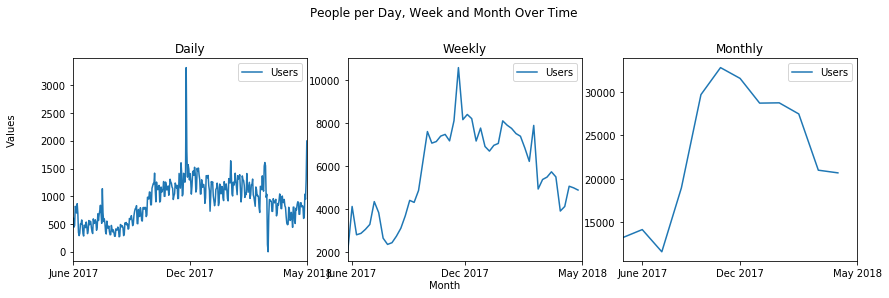

In [33]:
## Get min and max values from daily_visits to use as plot's xticks

daily_visits_min = daily_visits.index.min()
daily_visits_max = daily_visits.index.max()

## Create a dictionary that stores data needed for the graphs

plots_dict = {0: {'data': daily_visits['uid'],
                  'name': 'Daily'},
             1: {'data': weekly_visits['uid'],
                 'name': 'Weekly'},
             2: {'data': monthly_visits['uid'],
                 'name': 'Monthly'}
         }

## Plot the graph

fig, axes = plt.subplots(ncols=3, figsize=(12,4))
fig.tight_layout()
fig.text(0.5, 0, 'Month', ha='center');
fig.text(0, 0.5, 'Values', ha='center', rotation=90);
fig.suptitle('People per Day, Week and Month Over Time', fontsize=12);
fig.subplots_adjust(top=0.8, left=0.07);

## Create a subplot for each key in the dictionary

for plotNum in plots_dict:
    plots_dict[plotNum]['data'].plot(ax=axes[plotNum]);
    axes[plotNum].set_xticks([1,
                              len(plots_dict[plotNum]['data'])/2,
                              len(plots_dict[plotNum]['data'])])      
    axes[plotNum].set_xticklabels(['June 2017', 'Dec 2017', 'May 2018'])
    axes[plotNum].set_xlabel('')
    axes[plotNum].set_title(plots_dict[plotNum]['name'])
    axes[plotNum].legend(['Users'], loc='upper right')

All metrics share a pattern of an increase starting in June 2017 to a peak at around November-December 2017. Then a decrease starts until May 2018. Interestingly, the numbers were higher during the winter and decreased during summer. Perhaps users in Yandex.Afisha like to spend summer time in other activities.

**Daily users** went from 500 to a 1500 at the peak (with a short period of 3000 daily users). Then started a decrease to levels of a little bit more than 500 towards May 2018.

**Weekly users** saw a rise from 2000 weekly users at the start, to 8000 and even 10,000 weekly users, until eventually falling to 4500-5000 weekly users at May 2018.

**Monthly users** started lower than 15,000, quickly climbed to more than 30,000 around November-December, then started decreasing to around 20,000 monthly users.

In [34]:
## Get details of the highest and lowest daily users day

daily_visits[(daily_visits['uid']==daily_visits['uid'].min()) | (daily_visits['uid']==daily_visits['uid'].max())]

,session_date,uid
176,2017-11-24,3319
303,2018-03-31,1


The day with the highest daily users was 24-11-2017, and the day with lowest daily users was 31-03-2018. The 24th of November was Black Friday, and that's a good explanation to this rise, in addition to extra marketing efforts in this day. The 31st of March could be related to changes in marketing efforts during this day.

##### Conclusions
In this section, we calculated user activity metrics.
These are the mean values of these metrics:
- 907 people use the platform daily (DAU = 907).
- 5716 people use the platform weekly (WAU = 5716).
- 23,228 people use the platform monthly (MAU = 23228).

When looking at these metrics over time, we can see it differentiated during the period of analysis. Shortly after June 2017 the metrics started climbing, reaching a peak around November-December. Later on the numbers started decreasing, ending up in May 2018 higher than the starting point.

#### Sessions

**Number of Sessions**

In a similar way, number of sessions will be calculated using the `visits` dataset. Instead of calculating unique user ids, counting all visits will provide us the number of sessions per day.

First, let's calculate the average number of sessions per day for the whole period, alongside an histogram. Then, we'll see how the average number of sessions changed over time.

Average number of sessions per day: 987.36


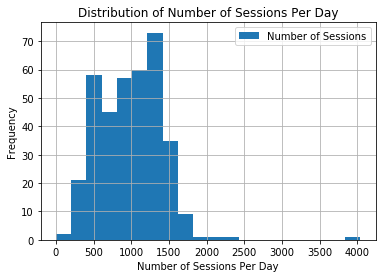

In [35]:
## Calculate number of sessions per day

sessions_per_day = visits.groupby('session_date').agg({'uid': 'count'})

## Print an average of number of sessions per day

print("Average number of sessions per day:", sessions_per_day['uid'].mean().round(2))

## Draw a histogram of number of sessions per day distribution

sessions_per_day_hist = sessions_per_day.plot(kind='hist', y='uid', bins=20, title='Distribution of Number of Sessions Per Day',
                     label='Number of Sessions', grid=True);
sessions_per_day_hist.set_xlabel("Number of Sessions Per Day");

While the average is a bit below 1,000, the most frequent value is around 1,250. Still, most days were relatively close to the average with 900-1400 sessions per day. Only about 20 days had less than 500 sessions, and fewer days saw 2,000 sessions or more. 

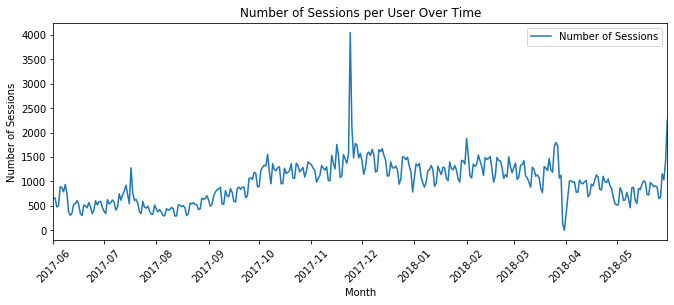

In [36]:
## Draw a line plot for number of sessions over time

sessions_over_time = sessions_per_day.plot(kind='line', title='Number of Sessions per User Over Time', rot=45,
                                          figsize=(11,4))
sessions_over_time.set_xlabel("Month");
sessions_over_time.set_ylabel('Number of Sessions');
sessions_over_time.legend(['Number of Sessions'], loc='upper right');

The graph for sessions over time is very similar to the daily users graph, which must mean that there are not many sessions per user. Still, number of sessions is a little higher. Here as well, Number of sessions is around 500 until September 2017, then it starts climbing to a peak of 1500 sessions per day (and 4000 sessions for a short time in December). Then, since March the number of sessions decreases to 500-1000 sessions per day.


**Session Length**

We shall now have a look in a similar manner at the session legnth. First, we will find the average session length for the whole period, and draw a histogram for the distribution of session legnths. Then, we will see how session length changed over time.

`visits` dataset stores start and end time of each session, so a new column must be created to find the session length. It will be the timedelta of start time and end time. We will store session length in minutes. It is important to mention that the visits timestamps did not store information to the seconds-level. This means that if a session lasted less than a minute, session length will be zero, session length of 1 to 2 minutes will be registered as 1 minute, and so on.

In [37]:
## Create a new column in `visits`, session_length

visits['session_length'] = (visits['end_ts'] - visits['start_ts']).dt.seconds / 60

## let's check it worked

visits.head()

,device,end_ts,source_id,start_ts,uid,session_year,session_month,session_week,session_date,session_length
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017,12,51,2017-12-20,18.0
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018,2,8,2018-02-19,28.0
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017,7,26,2017-07-01,0.0
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018,5,20,2018-05-20,24.0
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,2017,12,52,2017-12-27,0.0


In [38]:
## Let's get a general overview of session lengths

visits['session_length'].describe()

count    359400.000000
mean         10.725108
std          16.938913
min           0.000000
25%           2.000000
50%           5.000000
75%          14.000000
max        1408.000000
Name: session_length, dtype: float64

In [39]:
# the reviewer's code: if we use the .dt.total_seconds() method:
display(((visits['end_ts'] - visits['start_ts']).dt.total_seconds() / 60).describe())

# Let's see on the result - we have negative values...

# also, we could use the np.timedelta64(1, 'm') method from the NumPy and get the same result:
import numpy as np
((visits['end_ts'] - visits['start_ts']) / np.timedelta64(1, 'm')).describe()

count    359400.000000
mean         10.717095
std          16.618796
min         -46.000000
25%           2.000000
50%           5.000000
75%          14.000000
max         711.000000
dtype: float64

count    359400.000000
mean         10.717095
std          16.618796
min         -46.000000
25%           2.000000
50%           5.000000
75%          14.000000
max         711.000000
dtype: float64

In [40]:
## Count and share of extreme sessions

zero_session_length = visits.query('session_length==0')['session_length'].count()
high_session_length = visits.query('session_length>60')['session_length'].count()

print("Number of sessions with zero length: {}.".format(zero_session_length))
print("Percentage of sessions with zero length: {:.2%}".format(zero_session_length/len(visits)))
print()
print("Number of sessions lasted more than an hour: {}.".format(high_session_length))
print("Percentage of sessions lasted more than an hour: {:.2%}".format(high_session_length/len(visits)))

Number of sessions with zero length: 35794.
Percentage of sessions with zero length: 9.96%

Number of sessions lasted more than an hour: 6284.
Percentage of sessions lasted more than an hour: 1.75%


The most common session time is one minute. The average session length is almost 11 minutes, while the median is only 5 minutes. 75% of the sessions were not longer than 14 minutes. 

We can see that there are visits with session length zero - as mentioned, these are session that lasted less than a minute. Almost 9% of the visits had zero length. On the contrary, the max session is 1408 (23 hours), and this is most likely the result of a page left open and forgotten. A small share of the visits, smaller than 2%, had a session of more than an hour.

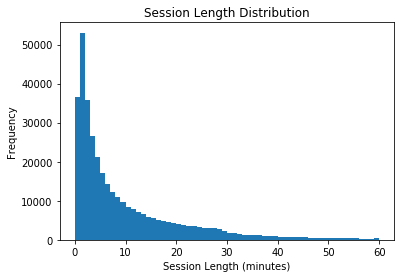

In [41]:
## Draw a histogram for session length

session_length_hist = visits['session_length'].plot(kind='hist', y='session_length', title='Session Length Distribution',
                                                   range=(0,60), bins=60)
session_length_hist.set_xlabel('Session Length (minutes)');

The histogram shows that the most frequent session length is 1 minute. Zero session length (up to 1 minute) and 2 minutes are also frequent. Further on, as session time rises, the frequency gets constantly smaller. 

Now, let's investigate session length over time. We will group each date and find its median session length.

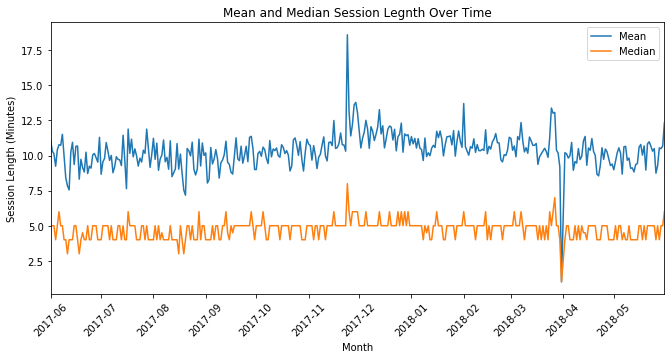

In [42]:
## Draw a line plot for the mean and median session length over time

session_length_over_time_mean = visits.groupby('session_date')['session_length'].mean()
session_length_over_time_median = visits.groupby('session_date')['session_length'].median()

session_length_over_time_plot_mean = session_length_over_time_mean.plot(kind='line', figsize=(11,5))
session_length_over_time_plot_median = session_length_over_time_median.plot(kind='line', rot=45)
plt.legend(labels=['Mean', 'Median']);
plt.title('Mean and Median Session Legnth Over Time');
plt.xlabel('Month');
plt.ylabel('Session Length (Minutes)');

In [43]:
## Find the day with highest average session length

print(session_length_over_time_mean[session_length_over_time_mean==session_length_over_time_mean.max()])

## Find the day with lowest average session length

print(session_length_over_time_mean[session_length_over_time_mean==session_length_over_time_mean.min()])

session_date
2017-11-24    18.608408
Name: session_length, dtype: float64
session_date
2018-03-31    1.0
Name: session_length, dtype: float64


Both the mean and the median are generally stable for the whole period, with the mean around 10 minutes and the median around 5. During the winter, between December 2017 to January 2018, the mean and the median both rise a bit to 11 and 6 respectively.

We can also see that at around the end of November 2017 (24-11-2017 - Black Friday) there's a peak in sessions length, and it drops in the end of March 2018 (31-03-2018). These dates correspond to the days with most\least daily users we found earlier. It turns out that during these days, also session length rose or dropped.

##### Conclusions

**The average number of sessions per day** was just below 1000, while most frequently, each day had around 1250 sessions. Over time, the number of sessions was quite similar to the number of daily users, which suggest that most users had roughly 1 session each. Here as well, the number rose between November and December.

As for **session length**, most of the sessions lasted several minutes, most frequently up to 3 minutes. The median is 5 minutes and average of almost 11 minutes, and the frquency drops as the time grows bigger. Over the year, session length stayed relatively stable around the mean and the median. Once again, during the winter (December and January) session length grew larger. 

Interestingly, two high and low record days in daily users were also introduced in the number of sessions and in session length, with highest average (and median) session length in 24-11-2017 and lowest average (and median) session length in 31-03-2018.

#### Retention

In this section we will investigate how often do users come back. We will aggregate sessions based on their user's first activity date, to see how many users continue to use the platform over time.

First, we need to find each user's first activity date and add it as a new column to the `visits` dataset.

In [44]:
## Find the first session date for each user id

first_session_date = visits.groupby(['uid'])['session_date'].min()
first_session_date.name = 'first_session_date'

## Join our new column to `visits` dataset

visits = visits.join(first_session_date, on='uid')

visits.head()

,device,end_ts,source_id,start_ts,uid,session_year,session_month,session_week,session_date,session_length,first_session_date
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017,12,51,2017-12-20,18.0,2017-12-20
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018,2,8,2018-02-19,28.0,2018-02-19
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017,7,26,2017-07-01,0.0,2017-07-01
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018,5,20,2018-05-20,24.0,2018-03-09
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,2017,12,52,2017-12-27,0.0,2017-12-27


Then, we'll create a column that will specify the session month (as a full datetime indication). Also, we will create a similar column of the first session month.

In [45]:
## Create the column `session_month_full` that will indicate the month in which the session took place

visits['session_month_full'] = visits['session_date'].astype('datetime64[M]')

## Create the column `first_session_month` that will indicate the month of the first session

visits['first_session_month'] = visits['first_session_date'].astype('datetime64[M]')

visits.head()

,device,end_ts,source_id,start_ts,uid,session_year,session_month,session_week,session_date,session_length,first_session_date,session_month_full,first_session_month
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017,12,51,2017-12-20,18.0,2017-12-20,2017-12-01,2017-12-01
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018,2,8,2018-02-19,28.0,2018-02-19,2018-02-01,2018-02-01
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017,7,26,2017-07-01,0.0,2017-07-01,2017-07-01,2017-07-01
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018,5,20,2018-05-20,24.0,2018-03-09,2018-05-01,2018-03-01
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,2017,12,52,2017-12-27,0.0,2017-12-27,2017-12-01,2017-12-01


Next, we will calculate the cohort lifetime of each session. Subtracting first session month from the month in which the session took place will give us the cohort lifetime. Then, we only need to convert the timedelta to represent the number of months.

In [46]:
## Get the cohort lifetime of each session

visits['cohort_lifetime'] = visits['session_month_full'] - visits['first_session_month']

## Convert to months

visits['cohort_lifetime'] = (visits['cohort_lifetime'] / np.timedelta64(1, 'M')).round().astype(int)

visits.sample(5)

,device,end_ts,source_id,start_ts,uid,session_year,session_month,session_week,session_date,session_length,first_session_date,session_month_full,first_session_month,cohort_lifetime
159116,desktop,2017-08-23 23:57:00,3,2017-08-23 23:57:00,12834117777877310742,2017,8,34,2017-08-23,0.0,2017-08-23,2017-08-01,2017-08-01,0
298888,desktop,2018-04-14 00:00:00,2,2018-04-13 23:57:00,9849933443572096000,2018,4,15,2018-04-13,3.0,2017-12-09,2018-04-01,2017-12-01,4
280178,desktop,2017-10-11 22:41:00,4,2017-10-11 22:00:00,4281075168414272526,2017,10,41,2017-10-11,41.0,2017-10-11,2017-10-01,2017-10-01,0
250363,desktop,2017-10-02 10:13:00,10,2017-10-02 10:13:00,18058901880642075731,2017,10,40,2017-10-02,0.0,2017-09-20,2017-10-01,2017-09-01,1
251718,desktop,2017-12-10 15:54:00,4,2017-12-10 15:48:00,6489466833444915209,2017,12,49,2017-12-10,6.0,2017-08-14,2017-12-01,2017-08-01,4


Now we can find the number of unique users for each cohort and cohort lifetime. We'll group the data by these two parameters and find the number of unique user ids.

In [47]:
## Create a new table, `cohorts`, that will store number of unique users per cohort and cohort age

cohorts = (
    visits.groupby(['first_session_month', 'cohort_lifetime'])
    .agg({'uid': 'nunique'})
    .reset_index()
)

cohorts.head()

,first_session_month,cohort_lifetime,uid
0,2017-06-01,0,13259
1,2017-06-01,1,1043
2,2017-06-01,2,713
3,2017-06-01,3,814
4,2017-06-01,4,909


Now, let's get the number of users for each cohort, where cohort lifetime is zero. Using this value, we will calculate retention for each cohort lifetime. We will merge it to `cohorts`.

In [48]:
## Calculate the initial users count

initial_users_count = cohorts[cohorts['cohort_lifetime']==0][['first_session_month', 'uid']]

## Rename initial_users_count's number of users column to 'cohort_users'

initial_users_count = initial_users_count.rename(columns={'uid': 'cohort_users'})

## Merge initial_users_count to the general `cohorts` table

cohorts = cohorts.merge(initial_users_count, on='first_session_month')

cohorts.head()

,first_session_month,cohort_lifetime,uid,cohort_users
0,2017-06-01,0,13259,13259
1,2017-06-01,1,1043,13259
2,2017-06-01,2,713,13259
3,2017-06-01,3,814,13259
4,2017-06-01,4,909,13259


All that is left is to calculate retention for each row and create a pivot table to present the retention rate per cohort age. Then, we'll present the data in a heatmap.

In [49]:
## Calculate retention rate

cohorts['retention'] = cohorts['uid'] / cohorts['cohort_users']

## Create a pivot table that will show retention rate by cohort and cohort age

retention_pivot = cohorts.pivot_table(
    index='first_session_month',
    columns='cohort_lifetime',
    values='retention',
    aggfunc='sum'
)

retention_pivot

cohort_lifetime,0,1,2,3,4,5,6,7,8,9,10,11
first_session_month,,,,,,,,,,,,
2017-06-01,1.0,0.078664,0.053775,0.061392,0.068557,0.071423,0.061015,0.057772,0.052342,0.050833,0.040652,0.044951
2017-07-01,1.0,0.056088,0.051294,0.056164,0.058219,0.048174,0.045358,0.045738,0.038813,0.028615,0.027473,NaN
2017-08-01,1.0,0.076908,0.062862,0.062764,0.050093,0.044004,0.036342,0.039485,0.027895,0.026029,NaN,NaN
2017-09-01,1.0,0.085489,0.069205,0.050706,0.039392,0.037835,0.035860,0.024186,0.022809,NaN,NaN,NaN
2017-10-01,1.0,0.078608,0.052239,0.038958,0.034261,0.032221,0.021365,0.020364,NaN,NaN,NaN,NaN
2017-11-01,1.0,0.078281,0.044113,0.038682,0.033727,0.023415,0.021800,NaN,NaN,NaN,NaN,NaN
2017-12-01,1.0,0.055802,0.037993,0.031107,0.020263,0.019036,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01,1.0,0.059715,0.039339,0.024973,0.020244,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02-01,1.0,0.057080,0.025454,0.020093,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


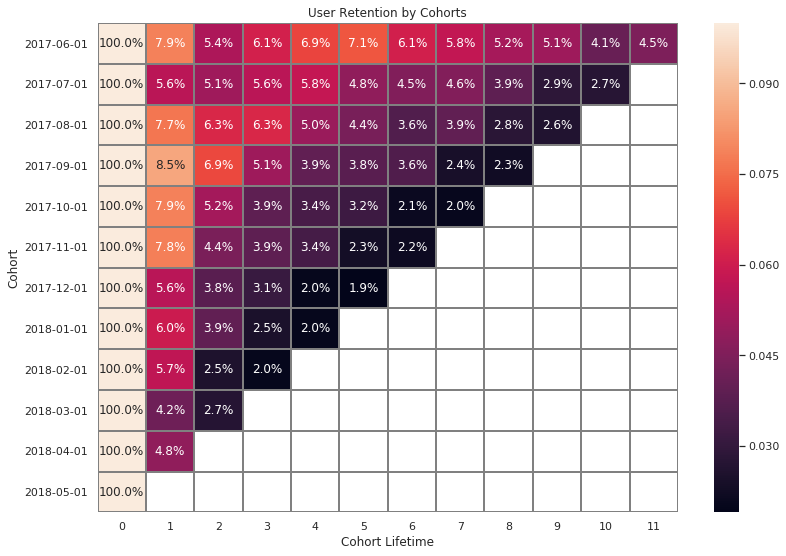

In [50]:
sns.set(style='white')
plt.figure(figsize=(13, 9))
plt.title('User Retention by Cohorts')
retention_heatmap = sns.heatmap(
    retention_pivot, annot=True, fmt='.1%', linewidths=1, linecolor='gray',
    yticklabels=retention_pivot.index.astype(str), vmax=0.1
);
retention_heatmap.set_xlabel("Cohort Lifetime");
retention_heatmap.set_ylabel("Cohort");

Retention rates drop more than 90% after one month in all cohorts, then usually go down a few more percentages.

Cohorts June 2017, and August-November 2017 have higher retention rates for the first month, and they maintain relatively higher retention rates going forward. July is an exception, with lower retention rates for the first 2-3 months, but rates then go back to normal. Perhaps this could be explained by the fact that more people go on summer vacations during July and August.

The first cohort (June 2017) does not enjoy the highest rates in the first 3 months, but it has the highest retention rates from the 4th month onward.

It can also be seen that retention rates steadily decreasing from September 2017, in all cohorts and all cohort ages. December 2017 should also be mentioned for having lower retention rates in the next 2 months. It is possible that many people visited with the intention to use the platform during the holidays. Then, in January, retention was naturally lower.

##### Conclusions

In this section, retention rates were calculated for each monthly cohort and cohort lifetime.

Retention rates were generally low with a drop of more than 90% in the first months. Retention rates in 2017 were generally higher than 2018, but they started decreasing since September 2017.

June 2017 (fist cohort in the analysis) maintained the highest rates over time, but as can be generally seen, summer vacations time (July-August) was less succesful in terms of retention rates. This can also be said about winter holidays, with December cohort having lower retention rates in the next 2 months. Perhaps many people intented to use the platform for a single time on the holidays, and did not come back in January and February.

#### Product Analysis Conclusions

In this section, product metrics were examined. 

First, **user activity** was calculated per day, week and month. An average of 907 people visited per day, 5,716 per week and 23,228 per month. We also saw that these numbers varied throught the year with lower numbers in June to September. Then they started rising, reaching a peak at November (more precisly, in 24-11-2017 - which was Black Friday). High rates maintained until March, then they started to descend again, reaching the lowest point in the end of March (31-03-18), then stabling on higher rates than the year before.

The **number of sessions** was just a little higher, with an average of 987 sessions per day. In most days, number of sessions was between 900 to 1250. Over time, session number was very similar to the changes in user activity.

As for the **session length**, half of them were no longer than 5 minutes. The average session length however, pushed up by some extremely long sessions, was almost 11 minutes. Still, most frequently, sessions lasted only one minute. These figured barely changed over time, with only a slight increase both in the median and average between November 2017 to January 2018.

**Retention rates** were calculated for each cohort and cohort age in months. The first month saw a drop of more than 90% in all cohorts. Generally speaking, 2017 had higher retention rates than 2018, with a steady decrease starting in September 2017. The most successful cohort over time was the first cohort (June 2017). Lower retention rates were seen in summer vacations time (July-August) in more than one cohort, this is probably the result of people being on vacation. Winter holidays probably also caused December 2017 cohort to have lower retention rates in its following two months.

### Sales

This section will focus on the sales of Yandex.Afisha. We will calculate the following sales metrics and see how they change over time and on different marketing sources:
- Time to conversion - When do people start buying? how long does it take from their first visit to the first order.
- Orders per period - We'll use months, as the time period for the analysis is a whole year. How many orders do user make during a month?
- Average purchase size
- LTV - How much money do each user bring?

#### Time to Conversion

In order to find when people start buying, we need to compare the first order of each user with their time of first visit. We will get these values from `visits` and `orders` datasets and merge them to a new dataset, `purchases`.

In [51]:
## Create a table `first_order` that will include user id and timestamp of the first order

first_order = orders.groupby(['uid'])['buy_ts'].min().reset_index()

## Rename the columns

first_order.columns = ['uid', 'first_order']

## Create a table `first_session` that will include user id and timestamp of the first session

first_session = visits.groupby(['uid'])['start_ts'].min().reset_index()

## Rename the columns

first_session.columns = ['uid', 'first_session']

## Merge both datasets together

purchases = first_session.merge(first_order, on='uid')

## Check the results...

purchases.head()

,uid,first_session,first_order
0,313578113262317,2017-09-18 22:49:00,2018-01-03 21:51:00
1,1575281904278712,2017-06-03 10:13:00,2017-06-03 10:13:00
2,2429014661409475,2017-10-11 17:14:00,2017-10-11 18:33:00
3,2464366381792757,2018-01-27 20:10:00,2018-01-28 15:54:00
4,2551852515556206,2017-11-24 10:14:00,2017-11-24 10:14:00


Now, let's calculate the difference between the first order to the first session. This will give us time of conversion for each user.

In [52]:
## Create `time_to_conversion` column

purchases['time_to_conversion'] = (purchases['first_order'] - purchases['first_session']).dt.days

purchases.head()

,uid,first_session,first_order,time_to_conversion
0,313578113262317,2017-09-18 22:49:00,2018-01-03 21:51:00,106
1,1575281904278712,2017-06-03 10:13:00,2017-06-03 10:13:00,0
2,2429014661409475,2017-10-11 17:14:00,2017-10-11 18:33:00,0
3,2464366381792757,2018-01-27 20:10:00,2018-01-28 15:54:00,0
4,2551852515556206,2017-11-24 10:14:00,2017-11-24 10:14:00,0


Now that the columns are set, time to investigate the results. Let's explore time to conversion using .describe() and a histogram.

In [53]:
purchases['time_to_conversion'].describe()

count    36523.000000
mean        16.729869
std         46.959088
min          0.000000
25%          0.000000
50%          0.000000
75%          2.000000
max        363.000000
Name: time_to_conversion, dtype: float64

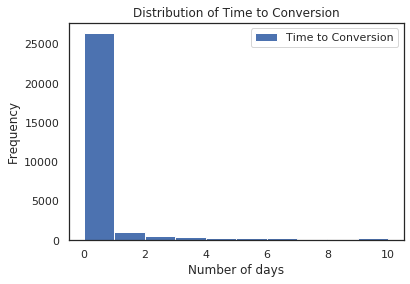

In [54]:
time_to_conversion_hist = purchases.plot(kind='hist', y='time_to_conversion', label='Time to Conversion',
                                        range=(0,10), title='Distribution of Time to Conversion')
time_to_conversion_hist.set_xlabel("Number of days");

In [55]:
first_session_buyers = purchases[purchases['time_to_conversion']==0]['time_to_conversion'].count()/len(purchases)
conversion_rate = purchases['uid'].nunique()/visits['uid'].nunique()

print("Total conversion rate is {:.2%}.".format(conversion_rate))
print("Share of people who ordered during their first session is {:.2%}.".format(first_session_buyers))

Total conversion rate is 16.01%.
Share of people who ordered during their first session is 72.18%.


It is very clear now that the majority of purchases happened during the users' first session - 72%. This is adding to a relatively high conversion rate of 16%. This could mean that the users find easily what they are looking for.

##### Conclusion

The majority of buyers placed there order during their first session, and conversion rate is 16.01%. Most users probably find easily find what they are looking for and place an order on their first visit.

#### Orders per Period

In this section we will use cohort analysis to find out the average number of orders per month. We will use `orders` and `first_order` tables to create the cohorts. Cohorts will be based on the first order month, and we will then see how many orders were placed for each cohort age. 

In [56]:
## Merge `orders` and `first_order` to a new table, `orders_cohorts`

orders_cohorts = orders.merge(first_order, on='uid')


orders_cohorts.head()

,buy_ts,revenue,uid,first_order
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01 00:10:00
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01 00:25:00
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01 00:27:00
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01 00:29:00
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01 07:58:00


In [57]:
## Convert `first_order` form timestamp to month presentation

orders_cohorts['first_order'] = orders_cohorts['first_order'].astype('datetime64[M]')

## Create a new column, `order_month` that will specify the month during which the order was made

orders_cohorts['order_month'] = orders_cohorts['buy_ts'].astype('datetime64[M]')

orders_cohorts.head()

,buy_ts,revenue,uid,first_order,order_month
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01,2017-06-01
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01,2017-06-01
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01,2017-06-01
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01,2017-06-01
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01,2017-06-01


In [58]:
## Calculate the number of unique buyers per cohort to a new table, and rename its columns 

cohort_sizes = orders_cohorts.groupby('first_order').agg({'uid': 'nunique'}).reset_index()
cohort_sizes.columns = ['first_order', 'cohort_size']

## Calculate the number of orders in each month to a new table, and rename its columns 

cohort_order_count = orders_cohorts.groupby(['first_order','order_month'])['uid'].count().reset_index()
cohort_order_count.columns = ['first_order', 'order_month', 'orders_num']

## Merge cohort size and number of orders per month to a new table, `cohort_order_count`

cohort_order_count = cohort_order_count.merge(cohort_sizes, on=['first_order'])

## Add column `cohort_age` to the table

cohort_order_count['cohort_age'] = ((cohort_order_count['order_month'] - cohort_order_count['first_order'])
                                / np.timedelta64(1,'M')).round().astype(int)

## Calculate number of orders per buyer for each month

cohort_order_count['orders_per_buyer'] = cohort_order_count['orders_num'] / cohort_order_count['cohort_size']

cohort_order_count.head()

,first_order,order_month,orders_num,cohort_size,cohort_age,orders_per_buyer
0,2017-06-01,2017-06-01,2354,2023,0,1.163618
1,2017-06-01,2017-07-01,177,2023,1,0.087494
2,2017-06-01,2017-08-01,174,2023,2,0.086011
3,2017-06-01,2017-09-01,226,2023,3,0.111715
4,2017-06-01,2017-10-01,292,2023,4,0.144340


In [59]:
## Create a pivot table to calculate orders per buyer for each cohort and cohort age

cohort_order_count_pivot=cohort_order_count.pivot_table(
    index='first_order', 
    columns='cohort_age', 
    values='orders_per_buyer', 
    aggfunc='sum'
).cumsum(axis=1)

cohort_order_count_pivot.round(2).fillna('')

cohort_age,0,1,2,3,4,5,6,7,8,9,10,11
first_order,,,,,,,,,,,,
2017-06-01,1.16,1.25,1.34,1.45,1.59,1.7,1.84,1.92,2.03,2.1,2.15,2.19
2017-07-01,1.14,1.19,1.25,1.31,1.34,1.39,1.42,1.44,1.47,1.49,1.51,
2017-08-01,1.12,1.2,1.27,1.33,1.39,1.44,1.47,1.53,1.56,1.6,,
2017-09-01,1.14,1.22,1.28,1.35,1.37,1.42,1.46,1.48,1.5,,,
2017-10-01,1.14,1.22,1.25,1.28,1.31,1.34,1.35,1.38,,,,
2017-11-01,1.18,1.28,1.32,1.37,1.41,1.42,1.45,,,,,
2017-12-01,1.15,1.21,1.26,1.3,1.32,1.34,,,,,,
2018-01-01,1.12,1.19,1.24,1.25,1.28,,,,,,,
2018-02-01,1.12,1.18,1.21,1.22,,,,,,,,


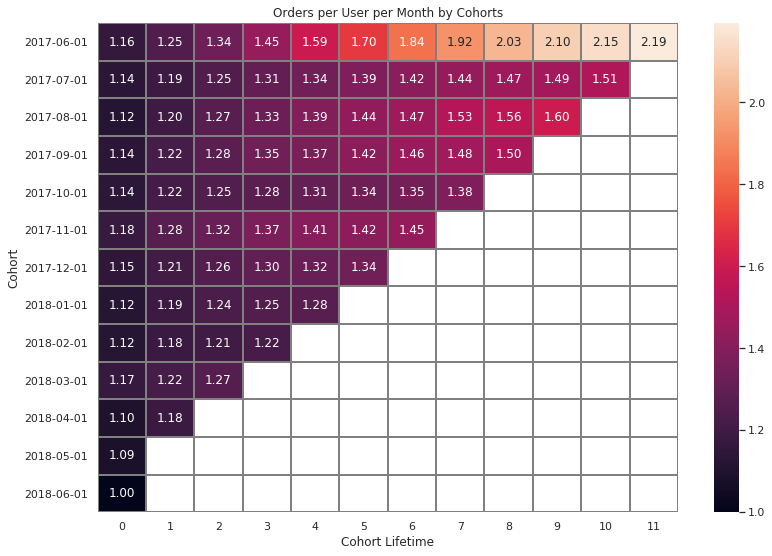

In [60]:
## Heatmap - orders per buyer per month

sns.set(style='white')
plt.figure(figsize=(13, 9))
plt.title('Orders per User per Month by Cohorts')
orders_per_buyer_heatmap = sns.heatmap(
    cohort_order_count_pivot, annot=True, fmt='.2f', linewidths=1, linecolor='gray',
    yticklabels=cohort_order_count_pivot.index.astype(str)
);
orders_per_buyer_heatmap.set_xlabel("Cohort Lifetime");
orders_per_buyer_heatmap.set_ylabel("Cohort");

The heatmap shows that users mostly place orders during their first month, in all cohorts. Much like the retention rates, after the first month the number of orders per users decreases drasticlly, way below 1 order per user.

Number of orders per user stays around the same level during most of the year for the first month, but in April and May 2018 it decreased a little. June 2018 only had one order, so we cannot determine a conclusion.

In most cohorts, the average number of orders continued to decrease over the time. Cohorts June, August, September and November 2017 had better results than the rest of the cohorts in terms of orders per buyer per month.


##### Orders per User per Month by Source 

We will now take a look at how sources affected the number of orders per user they brought. First, we will generate an average for the whole period. Then, we will see how it changes throught the year.

In [61]:
## Get source_id for each user id

user_per_source = visits.sort_values('start_ts').groupby('uid')['source_id'].first()

## Merge it with `orders` table

cohort_order_count_sources = orders.merge(user_per_source, on='uid')

## Calculate order month

cohort_order_count_sources['order_month'] = cohort_order_count_sources['buy_ts'].astype('datetime64[M]')

## Group by source, get number of users from each source and number of orders, then rename columns

cohorts_sources = cohort_order_count_sources.groupby(['source_id','order_month']).agg({'uid': ['nunique', 'count']}).reset_index()
cohorts_sources.columns = ['source_id', 'order_month', 'users', 'orders']

## Calculate number of orders per user for each month and source id

cohorts_sources['orders_per_user'] = cohorts_sources['orders'] / cohorts_sources['users']

## Calculate the average of orders_per_user for month for each source id

cohorts_sources.groupby('source_id')['orders_per_user'].mean().sort_values(ascending=False)


source_id
1     1.545545
2     1.473232
5     1.228022
9     1.193568
3     1.139453
4     1.119128
10    1.098093
7     1.000000
Name: orders_per_user, dtype: float64

Users from sources 1 and 2 order more than users in the rest of the sources.

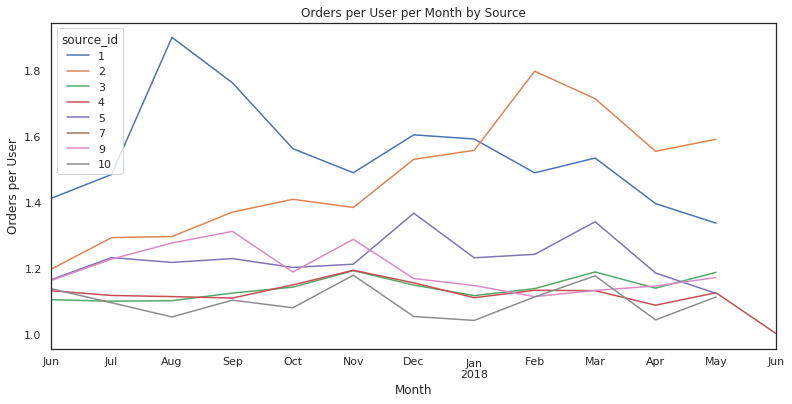

In [62]:
## Plot a line plot of orders per user over time

cohorts_sources_plot = cohorts_sources.pivot_table(
    index='order_month',
    columns='source_id',
    values='orders_per_user',
    aggfunc='sum'
).plot(figsize=(13,6), title='Orders per User per Month by Source');
cohorts_sources_plot.set_xlabel('Month');
cohorts_sources_plot.set_ylabel('Orders per User');

The line plot shows the same image - sources 1 and 2 get a higher number of orders per user throught the year. Source 1 maintains high rates (1.5-1.6 orders per user) most of the year, but starts decreasing in March.
source 2 only reaches these levels from November 2017, but since January its rates are higher than source 1.

The rest of the sources are far behind, with only source 5 and source 9 getting closer for parts of the year.

##### Orders per User per Month by Device 

We will go through the same process for devices, checking the average for the whole period and a line plot to see the change over time.

In [63]:
## Get device for each user id

user_per_device = visits.sort_values('start_ts').groupby('uid')[['device']].first()

cohort_order_count_device = cohort_order_count_sources.merge(user_per_device, on='uid')

## Group by source, get number of users from each device and number of orders, then rename columns

cohorts_device = cohort_order_count_device.groupby(['device','order_month']).agg({'uid': ['nunique', 'count']}).reset_index()
cohorts_device.columns = ['device', 'order_month', 'users', 'orders']

## Calculate number of orders per user for each month and device

cohorts_device['orders_per_user'] = cohorts_device['orders'] / cohorts_device['users']

## Calculate the average of orders_per_user for month for each device

cohorts_device.groupby('device')['orders_per_user'].mean().sort_values(ascending=False)

device
desktop    1.217818
touch      1.170406
Name: orders_per_user, dtype: float64

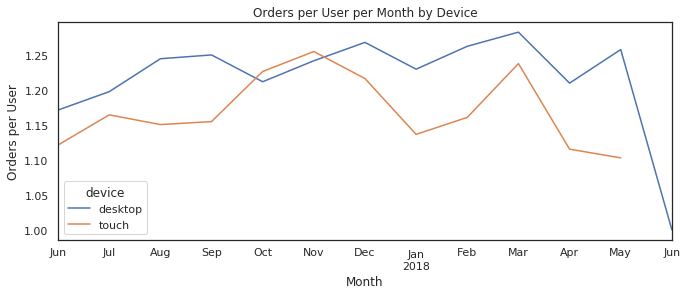

In [64]:
## Plot a line plot of orders per user over time

cohorts_device_plot = cohorts_device.pivot_table(
    index='order_month',
    columns='device',
    values='orders_per_user',
    aggfunc='sum'
).plot(figsize=(11,4), title='Orders per User per Month by Device');
cohorts_device_plot.set_xlabel('Month');
cohorts_device_plot.set_ylabel('Orders per User');

Desktop users has higher orders per user rate than touch. Over time, desktop users maintained higher rates, with only 2 months where touch users equaled or passed desktop users (October and November, possibly related to marketing efforts towards Black Friday).

##### Conclusions

In this section, we analyzed the number of orders that each user made during a month. Using cohort analysis, we saw that the average number of varied significantly in the first month and the rest of the year. In the first month, the users had around 1.15 orders per user. However, in the next month the number dropped to 0.1 and less orders per user in a month, and continued decreasing going forward.

**Sources** also affected the orders per user rate, with sources 1 and 2 bringing users who ordered more than the rest. Perhaps these sources work better in targeting relevant users to the platform. **Devices**, however, had a smaller impact, but with an advantage to desktop users over touch ones. The gap might not be large enough to suggest there's a problem with the touch version of the platform, but perhaps it could be made easier to use so the rates will be closer.

#### Average Purchase Size

To calculate purchase size, we will use the `orders` table. Revenue already sums the purchase size for each order. Purchase size will also be compared between different sources and devices. We can use the table created in the previous section (`cohort_order_count_device`), since it contains all the information we need.

In [65]:
## Print statistics

cohort_order_count_device['revenue'].describe()

count    50415.000000
mean         4.999647
std         21.818359
min          0.000000
25%          1.220000
50%          2.500000
75%          4.890000
max       2633.280000
Name: revenue, dtype: float64

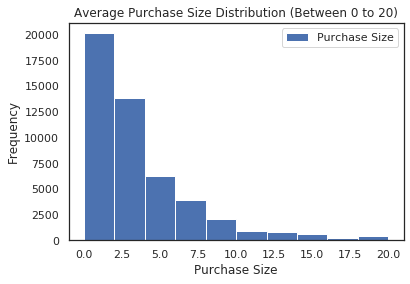

In [66]:
## Draw a histogram of purchase size

average_purchase_size_hist = cohort_order_count_device.plot(kind='hist', y='revenue', range=(0,20),
                              title='Average Purchase Size Distribution (Between 0 to 20)', label='Purchase Size');
average_purchase_size_hist.set_xlabel("Purchase Size");

The average purchase size is 5, while the median is smaller - only 2.5. Actually, 75% of the purchases were less than 5, and the frequency continues to decrease going forward. A small number of very high purchase sizes push the mean higher than most of the data. As mentioned earlier, the reason to the great differences in purchase sizes could be that the lower size purchases were made by ordinary users, while the large purchases were made by large organizations. 

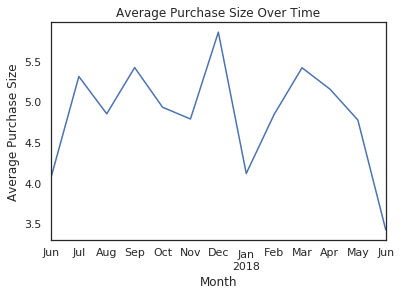

In [67]:
## Get average order size over time and plot

purchase_size_over_time = cohort_order_count_device.groupby('order_month')['revenue'].mean()

purchase_size_over_time_plot = purchase_size_over_time.plot(title='Average Purchase Size Over Time')
purchase_size_over_time_plot.set_xlabel('Month');
purchase_size_over_time_plot.set_ylabel('Average Purchase Size');

Average purchase size doesn't change much over time, and stays generally around 5, with a peak in December 2017 where it rose over 5.5, and a low in January 2018, where it almost reached 4.

##### Average Purchase Size by Source

In this section, average purchase size will be examined by the source Id. 

In [68]:
## Calculate average purchase size for each source

cohort_order_count_device.groupby('source_id')['revenue'].mean().sort_values(ascending=False).reset_index()

,source_id,revenue
0,2,7.340990
1,1,5.952623
2,5,5.594729
3,4,4.396807
4,3,4.101982
5,9,3.496903
6,10,2.849123
7,7,1.220000


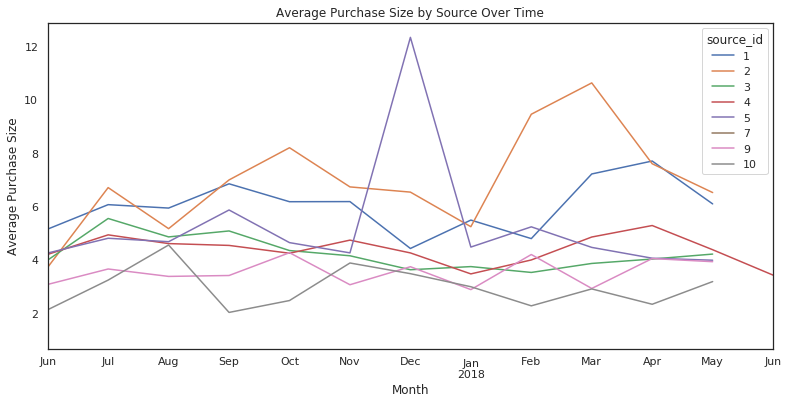

In [69]:
## Plot average purchase size over time by sources (using a pivot table)

average_purchase_size_source = cohort_order_count_device.pivot_table(
    index='order_month',
    columns='source_id',
    values='revenue',
    aggfunc='mean'
).plot(figsize=(13,6), title='Average Purchase Size by Source Over Time');
average_purchase_size_source.set_xlabel('Month');
average_purchase_size_source.set_ylabel('Average Purchase Size');

As can be seen, sources 2 and 1 are once again at the top. Source 2 has the highest average purchase size, and 1 is behind. During 2017, source 1 had similar rates as source 2, but in January to March 2018 source 2 had a higher average.

Source 5 also had a high overall average, with a peak in December 2017 where the average purchase size reached 14.

Other than that, the rest of the sources maintained a relatively stable purchase rate at around 4, with source 10 at smaller rates, between 2 to 4. 

##### Average Purchase Size by Device

We will conduct the same analysis for devices.

In [70]:
## Calculate average purchase size for each device

cohort_order_count_device.groupby('device')['revenue'].mean().sort_values(ascending=False).reset_index()

,device,revenue
0,desktop,5.163578
1,touch,4.292520


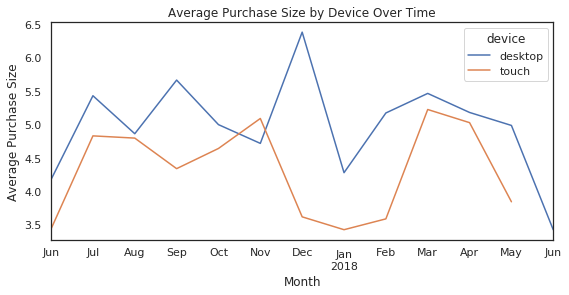

In [71]:
## Plot average purchase by device over time (using a pivot table)

average_purchase_size_device = cohort_order_count_device.pivot_table(
    index='order_month',
    columns='device',
    values='revenue',
    aggfunc='mean'
).plot(figsize=(9,4), title='Average Purchase Size by Device Over Time');
average_purchase_size_device.set_xlabel('Month');
average_purchase_size_device.set_ylabel('Average Purchase Size');

Once again, desktop users has the lead with higher average purcahse size. Touch users had higher average only in November 2017, as mentioned, possibly related to Black Friday marketing. Interestingly, while Desktop users reached a peak in December 2017 to an average of almost 6.5, touch users descended to a low of 3.5. The gap between the two was larger in winter time, perhaps because people spend more time in their homes, near their desktop.

It is worth to mention that the desktop plot resembles much the plot of the average purchase size of sources 2 and 5. It could be that these sources address desktop users more than others, and the reason for the increase in average purchase size could be the result an increase in marketing efforts for these sources.

##### Conclusions

The **average purchase size** for the whole period of analysis was 5, but most purchases were actually lower, with a median of 2.5. Average was pushed up by extreme values. The average purchase size reached a peak of more than 5.5 in December 2017, possibly because of the holidays, and a low of 4 in January 2018.

**Source 2** had the highest average purchase size among the sources, with source 1 and 5 behind. **Desktop** users had a higher average purchase over touch users. Similarity between the graphs of desktop users and sources 2 and 5 led to a possibility that these sources are more related to desktop users. 

#### LTV

Calculating the LTV (Life time value) of each user will let us know how much money each user bring to Yandex.Afisha. To do so, we will use cohort analysis. For each cohort and cohort age we will calculate the average revenue per user.

In [72]:
## Get first order time from `first_order` table

ltv = orders.merge(first_order, on='uid')

## Convert first_order to month representation and create the column `order_month`

ltv['first_order'] = ltv['first_order'].astype('datetime64[M]')
ltv['order_month'] = ltv['buy_ts'].astype('datetime64[M]')

## Find cohort sizes

ltv_cohort_sizes = ltv.groupby('first_order').agg({'uid': 'nunique'}).reset_index()
ltv_cohort_sizes.columns = ['first_order', 'n_buyers']

## Find revenue per cohort

ltv_cohorts = ltv.groupby(['first_order','order_month']).agg({'revenue': 'sum'}).reset_index()

We created two tables: `ltv_cohort_sizes` contains the number of users in each cohort. `ltv_cohorts` includes total revenue in each month and cohort. We need to merge them together, and then we will be able to calculate cohort ages and ltv.

In [73]:
## Merge both tables to one

ltv_report = pd.merge(ltv_cohorts, ltv_cohort_sizes, on='first_order')

## Calculate cohort ages and represent it as number of months
ltv_report['cohort_age'] = (ltv_report['order_month'] - ltv_report['first_order']) / np.timedelta64(1, 'M')
ltv_report['cohort_age'] = ltv_report['cohort_age'].round().astype('int')

## Calculate ltv - revenue divided by number of buyers

ltv_report['ltv'] = ltv_report['revenue'] / ltv_report['n_buyers']

ltv_report.head()

,first_order,order_month,revenue,n_buyers,cohort_age,ltv
0,2017-06-01,2017-06-01,9557.49,2023,0,4.724414
1,2017-06-01,2017-07-01,981.82,2023,1,0.485329
2,2017-06-01,2017-08-01,885.34,2023,2,0.437637
3,2017-06-01,2017-09-01,1931.30,2023,3,0.954671
4,2017-06-01,2017-10-01,2068.58,2023,4,1.022531


Now we can create a pivot table that will show the LTV per cohort and cohort age. Then, the data will be represented in a heatmap. We used cumulative sum so we can compare the different cohorts.

In [74]:
## Create a pivot table that will show LTV per cohort and cohort age

output = ltv_report.pivot_table(
    index='first_order',
    columns='cohort_age',
    values='ltv',
    aggfunc='mean'
).cumsum(axis=1).round(2)

output.fillna('')

cohort_age,0,1,2,3,4,5,6,7,8,9,10,11
first_order,,,,,,,,,,,,
2017-06-01,4.72,5.21,5.65,6.6,7.62,8.36,9.31,9.89,10.45,11.05,11.62,11.88
2017-07-01,6.01,6.35,6.97,7.33,7.5,7.66,7.78,7.92,8.08,8.23,8.39,
2017-08-01,5.28,5.75,6.21,6.6,7.09,7.38,7.59,7.99,8.28,8.47,,
2017-09-01,5.64,6.76,7.28,11.26,11.66,12.31,13.01,13.25,13.44,,,
2017-10-01,5.00,5.54,5.73,5.89,6.04,6.16,6.24,6.36,,,,
2017-11-01,5.15,5.55,5.75,6.08,6.23,6.28,6.4,,,,,
2017-12-01,4.74,5,5.92,6.99,7.3,7.64,,,,,,
2018-01-01,4.14,4.43,4.73,4.88,4.94,,,,,,,
2018-02-01,4.16,4.44,4.51,4.59,,,,,,,,


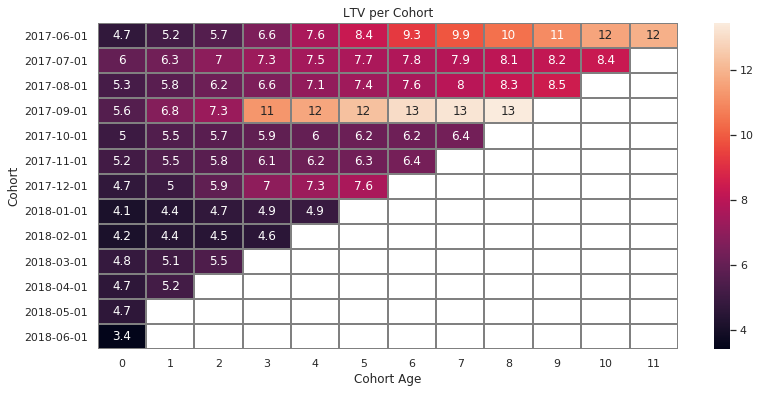

In [75]:
## Draw a heatmap of LTV

output.index = output.index.astype(str)
sns.set(style='white')
plt.figure(figsize=(13, 6))
plt.title('LTV per Cohort')
ltv_heatmap = sns.heatmap(output, annot=True,
           linewidths=1, linecolor='grey');
ltv_heatmap.set_xlabel('Cohort Age');
ltv_heatmap.set_ylabel('Cohort');

It is visible that cohort September 2017 was the most successful in terms of LTV. June, July, August and December 2017 were also quite succesful over time. It is visible also that LTV rates in 2017 were mostly higher than those in 2018. This could be due to seasonality.

The biggest leap in September 2017 cohort was in December (cohort age=3), and this could be explained by the holidays. We can see similar leap only in June 2017, but in this cohort there are bigger leaps also in later months. Other cohorts experience a more moderate rise in LTV torwards winter holidays. 

##### Conclusion

In this section, LTV was calculated per cohorts. It was visible that the highest cohorts in terms of LTV were September 2017 and June 2017. September 2017 had a big leap in December, probably due to the winter holidays, while other cohorts had a more moderate rise at that time. Overall, 2017 months had higher LTV rates than those in 2018. 

#### Sales Conclusions

In this section, sales metrics were calculated and analyzed. 

**Time to Conversion**
First, time to conversion was investigated. Most users (72%) place their first order in their first session. A small number do it after not more than 5 days. Conversion rate is 16%. These details mean that users easily find what they are looking for in the platform.

**Orders per Period**
We then looked at the number of orders per month using cohort analysis. The results were similar to those we saw in time to conversion - in all cohorts, there are 1.15 orders per user in the first month. Then the number drops significantly to about 0.1 orders per user in the second month. In most cohorts, the number continues to slowly decrease.

Comparing different sources and devices, we find out that the highest orders per user per month rate was achieved by source 1 and source 2. As for devices, desktop users had better average than touch users.

**Average Purchase Size**
The average purchase size for the whole period was 5. This number was pushed up by some extremely large purchase sizes, as the median was 2.5. The average purchase size did not change too much throught the year. It reached a peak in December 2017 and a record low in January 2018.

Average purchase size varied significantly by source: Source 2 was leading with an average of 7 - much higher than the overall average. Source 1 and 5 were also a little higher than the general average. Source 2 reached peaks in February to March, but the highest average of 12 achieved by source 5 in December 2017. Very much like sources 2 and 5, desktop users had a peak at these times. It is likely that sources 2 and 5 were more related to desktop users. Overall, desktop users had higher average purchase size than touch ones, except for November, possibly as a result of Black Friday marketing efforts.

**LTV**

Life time value was calculated for each cohort and cohort age. It was visible that cohort September 2017 was the most successful in these terms, with June 2017 also maintaining relatively high rates. Overall, 2017 enjoyed better LTV rates than 2018, possibly due to seasonality.

### Marketing

This section will address marketing metrics, mainly using the `costs` dataset. 
We will be calculating the following metrics:
- Investment - how much money was spent: overall, per source and over time?
- CAC - How much id customer acquisition from each of the sources cost?
- ROI\ROMI - How worthwile were the investments?


#### Investment

In this section, the costs of the platform will be analyzed by 3 parameters: overall investment, investment by source and investment over time.

**Overall Investment**

The overall investment will simply be a sum of all the costs in `costs` dataset.

In [76]:
## Calculate overall investment

overall_investment = costs['costs'].sum()

print("The overall investment in Yandex.Afisha was {}".format(overall_investment))

The overall investment in Yandex.Afisha was 329131.62


The overall investment sums up to 329,131. 

**Investment per Source**

Let's see now investment per source. We'll group the data by source_id and sum the costs.

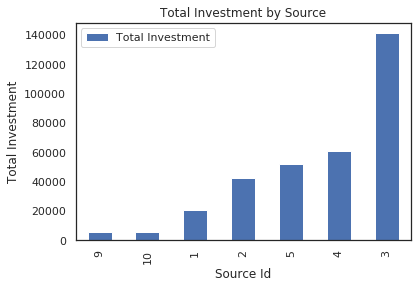

In [77]:
## Calculate total investment by source

total_investment_by_source = costs.groupby('source_id')['costs'].sum().sort_values().reset_index()

## Bar plot of total investment by source

total_investment_by_source_plot = total_investment_by_source.plot(kind='bar', x='source_id', y='costs',
                                                                 title='Total Investment by Source',
                                                                 label='Total Investment');

total_investment_by_source_plot.set_xlabel('Source Id');
total_investment_by_source_plot.set_ylabel('Total Investment');

Source 3 received the largest investment by far, more than twice than the runner-up, source 4. Interestingly, source 2 and 1 which were mentioned as successful in previous sections, received a relatively lower investment. 

**Investment Over Time**

Let's see how investment changed over time, overall and for each source. We will calculate it per month, so the graph will be more readable.

In [78]:
## Getting the month of each cost entry

costs['cost_month'] = costs['dt'].astype('datetime64[M]')

## Group data by months \ dates

costs_over_time = costs.groupby('cost_month')['costs'].sum().reset_index()
costs_over_time_daily = costs.groupby('dt')['costs'].sum().reset_index()

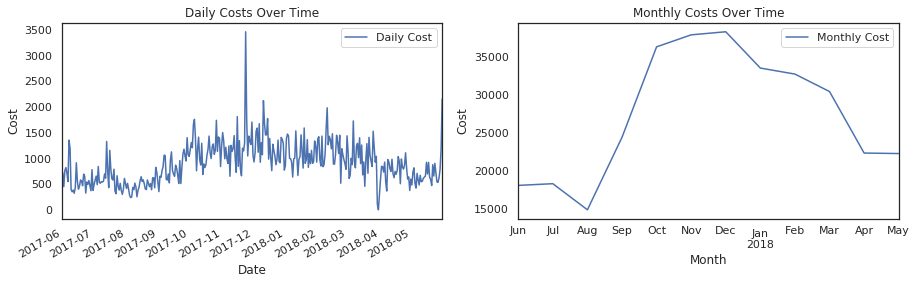

In [79]:
fig, axes = plt.subplots(ncols=2, figsize=(15,4))

## Daily plot

costs_over_time_daily_plot = costs_over_time_daily.plot(ax=axes[0], x='dt', y='costs', label='Daily Cost',
                                                       title='Daily Costs Over Time');
costs_over_time_daily_plot.set_xlabel('Date');
costs_over_time_daily_plot.set_ylabel('Cost');

## Monthly plot

costs_over_time_plot = costs_over_time.plot(ax=axes[1], x='cost_month', y='costs', label='Monthly Cost',
                                           title='Monthly Costs Over Time');
costs_over_time_plot.set_xlabel('Month');
costs_over_time_plot.set_ylabel('Cost');

The graphs are almost identical to the DAU and MAU graphs! We can even see the peak in costs in the end of November, and the low in the end of March, which led to highest and lowest record in almost all other product and sales metrics. Let's see if these are realy the same dates.

In [80]:
## Find the day with highest investment

costs_time = costs.groupby(['dt'])['costs'].sum().reset_index()

costs_time[(costs_time['costs']==costs_time['costs'].max()) | (costs_time['costs']==costs_time['costs'].min())]

,dt,costs
176,2017-11-24,3458.86
303,2018-03-31,0.70


Indeed, these are the same date, and one mistory is solved: the high and low record days in terms of user activity are the result of marketing investment during these days.

Let's see now how investment in each source varied over time.

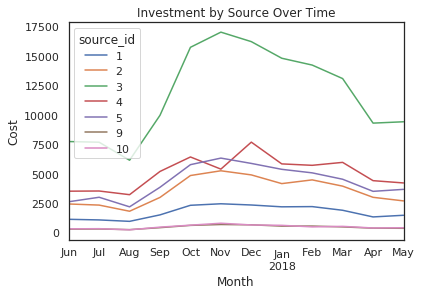

In [81]:
## Create a pivot table of costs per source and month, then plot it 

costs_source_over_time = costs.pivot_table(
    index='cost_month',
    columns='source_id',
    values='costs',
    aggfunc='sum'
).plot(title='Investment by Source Over Time');

costs_source_over_time.set_xlabel('Month');
costs_source_over_time.set_ylabel('Cost');

Investment was higher for source 3 throughout the whole year. Most sources saw an increase in investment betwen September and March, but it was more massively in source 3, and the gap from other sources grew bigger during this period.

#### CAC

In this section we will calculate the costumer acquisition cost - how much did customer acquisition costed Yandex.Afisha. We will first calculate general CAC metrics and then by source.

To do so, we need to get the number of new buyers for each month. Then, we will take the sum costs for each month, and merge the data together. I will use `first_order` table which already contains information of the first order.

In [82]:
## Convert first_order timestamp to month representation

first_order['first_order_month'] = first_order['first_order'].astype('datetime64[M]')

## Group each month and the number of new users, rename column names

n_buyers = first_order.groupby('first_order_month').agg({'uid': 'nunique'}).reset_index()
n_buyers.columns = ['cost_month', 'n_buyers']

## Create 'costs_by_month' table

costs_by_month = costs.groupby(['cost_month'])['costs'].sum().reset_index()

## Merge both tables

costs_by_month = costs_by_month.merge(n_buyers, on='cost_month')

costs_by_month.head()

,cost_month,costs,n_buyers
0,2017-06-01,18015.00,2023
1,2017-07-01,18240.59,1923
2,2017-08-01,14790.54,1370
3,2017-09-01,24368.91,2581
4,2017-10-01,36322.88,4340


Now all is left is to divide costs in n_buyers to understand what was the cost for each buyer.

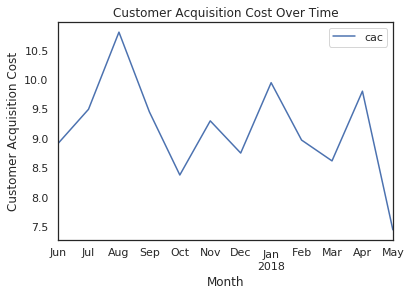

In [83]:
## Calculate CAC

costs_by_month['cac'] = costs_by_month['costs'] / costs_by_month['n_buyers']

CAC_plot = costs_by_month.plot(x='cost_month', y='cac');
CAC_plot.set_xlabel('Month');
CAC_plot.set_ylabel('Customer Acquisition Cost');
CAC_plot.set_title('Customer Acquisition Cost Over Time');

In [84]:
CAC_avg = costs_by_month['cac'].mean()

print("CAC average for the whole peroid of analysis is {:.2f}.".format(CAC_avg))

CAC average for the whole peroid of analysis is 9.15.


The average customer acquisition cost for the whole period was 9.15. However, this number changed over time. In august, for example, it was more expensive to attract buyers - CAC went over 10.5. Between September to December, though, CAC was lower and reached 8.5 in October.

**CAC by Source**

Let's investigate how CAC changed for each source. We will calculate it in a similar manner. We want to find the number of users that came from each source for each month. The information regarding the source that brought each user is in `visits` table. We will then merge it with `first_order` table and get the number of uninque users in each month and source.

In [85]:
## Find the first source of each user

first_source = visits.sort_values('start_ts').groupby('uid').first()['source_id'].reset_index()


In [86]:
## Merge first_order table with first_source

source_first_order = first_order.merge(first_source, on='uid', how='left')

## Group by month and source Id to find the number of unique new buyers

source_n_buyers = source_first_order.groupby(['first_order_month', 'source_id']).agg({'uid': 'nunique'}).reset_index()
source_n_buyers.columns = ['cost_month', 'source_id', 'n_buyers']

In [87]:
## Sum costs per month and source Id

costs_month_source = costs.groupby(['cost_month', 'source_id'])['costs'].sum().reset_index()

## Merge this info with data of n_buyers from each source

costs_month_source = costs_month_source.merge(source_n_buyers, on=['cost_month','source_id'])

## Calculate CAC - costs divided by number of users

costs_month_source['cac'] = costs_month_source['costs'] / costs_month_source['n_buyers']

costs_month_source.head()

,cost_month,source_id,costs,n_buyers,cac
0,2017-06-01,1,1125.61,190,5.924263
1,2017-06-01,2,2427.38,235,10.329277
2,2017-06-01,3,7731.65,638,12.118574
3,2017-06-01,4,3514.80,413,8.510412
4,2017-06-01,5,2616.12,384,6.812813


CAC is now calculated per each source and month. Let's see now what is the average CAC from each source and how did it change over time.

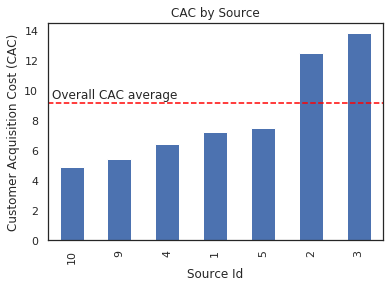

In [88]:
## Plot CAC per source Id 

CAC_by_source = costs_month_source.groupby('source_id')['cac'].mean().sort_values()

CAC_by_source_plot = CAC_by_source.plot(kind='bar', title='CAC by Source', label='CAC')
CAC_by_source_plot.set_xlabel('Source Id');
CAC_by_source_plot.set_ylabel('Customer Acquisition Cost (CAC)');
CAC_by_source_plot.hlines(CAC_avg, -1, CAC_by_source_plot.get_xticks().max()+1,
                          linestyle='--', color='red', label='mean');
CAC_by_source_plot.text(-0.4, CAC_avg+0.5, 'Overall CAC average ', ha='left', va='center');

Interestingly, sources 3 and 2 had the highest customer acquisition cost. Source 2 may brought many visitors and orders, but its cost was relatively high. The large amounts that were spent on source 3 were probably less efficient. 

**CAC Over Time**

Let's see how CAC rates changed for each source over time.

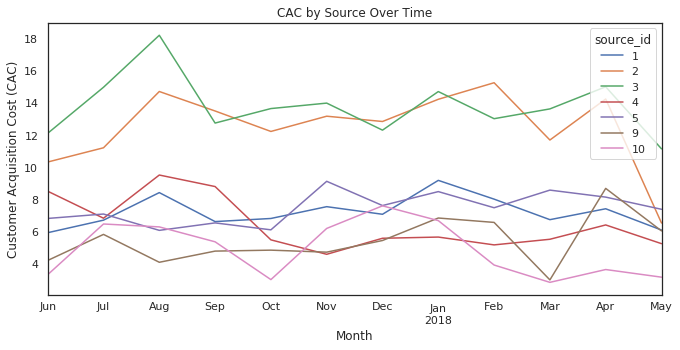

In [89]:
## Plot CAC over time per source Id

CAC_by_source_over_time = costs_month_source.pivot_table(
    index='cost_month',
    columns='source_id',
    values='cac',
    aggfunc='mean'
).plot(title='CAC by Source Over Time', figsize=(11,5))
CAC_by_source_over_time.set_xlabel('Month');
CAC_by_source_over_time.set_ylabel('Customer Acquisition Cost (CAC)');

CAC rates did not change much over the time. August saw a rise in CAC in several sources, possibly because of summer vacations. October was less costly mainly to source 10 and 5, and so was March for sources 2 and 9. These trends also account for the high and low records in the overall CAC.

##### Conclusions

In this section, customer acquisition costs were calculated, first overall and then by source. The **overall average CAC** was 9.15, and it was mostly stable around this area. Exceptions to that were an increase in August 2017 to over 10.5 and a decrease in October 2017 to a level of 8.5.

Sources 2 and 3 had the highest CAC rates of around 12-14. The rest of the sources were lower than the overall CAC average. CAC rates did not change much, with the exception of changes in August, October and other months, as could also be seen in the general CAC over time.

#### ROI

In this section we will use some of the metrics we calculated so far, to understend how worthwiel were the investments. This will be done by calculating ROI - return on investment. We will investigate ROI per cohort and per source.

ROI is generally calculated as LTV / CAC. We will use the metrics we already calculated.

**ROI per Cohort**

We already have calculations of LTV per cohort in `ltv_report`. Let's add CAC data from `costs_by_month`.

In [90]:
## Merge CAC data to LTV data

ROI_cohorts = ltv_report.merge(costs_by_month, left_on='first_order', right_on='cost_month')

## Calculate ROI

ROI_cohorts['roi'] = ROI_cohorts['ltv'] / ROI_cohorts['cac']

ROI_cohorts

,first_order,order_month,revenue,n_buyers_x,cohort_age,ltv,cost_month,costs,n_buyers_y,cac,roi
0,2017-06-01,2017-06-01,9557.49,2023,0,4.724414,2017-06-01,18015.00,2023,8.905091,0.530530
1,2017-06-01,2017-07-01,981.82,2023,1,0.485329,2017-06-01,18015.00,2023,8.905091,0.054500
2,2017-06-01,2017-08-01,885.34,2023,2,0.437637,2017-06-01,18015.00,2023,8.905091,0.049145
3,2017-06-01,2017-09-01,1931.30,2023,3,0.954671,2017-06-01,18015.00,2023,8.905091,0.107205
4,2017-06-01,2017-10-01,2068.58,2023,4,1.022531,2017-06-01,18015.00,2023,8.905091,0.114825
...,...,...,...,...,...,...,...,...,...,...,...
73,2018-03-01,2018-04-01,1063.05,3533,1,0.300892,2018-03-01,30415.27,3533,8.608907,0.034951
74,2018-03-01,2018-05-01,1114.87,3533,2,0.315559,2018-03-01,30415.27,3533,8.608907,0.036655
75,2018-04-01,2018-04-01,10600.69,2276,0,4.657597,2018-04-01,22289.38,2276,9.793225,0.475594
76,2018-04-01,2018-05-01,1209.92,2276,1,0.531599,2018-04-01,22289.38,2276,9.793225,0.054282


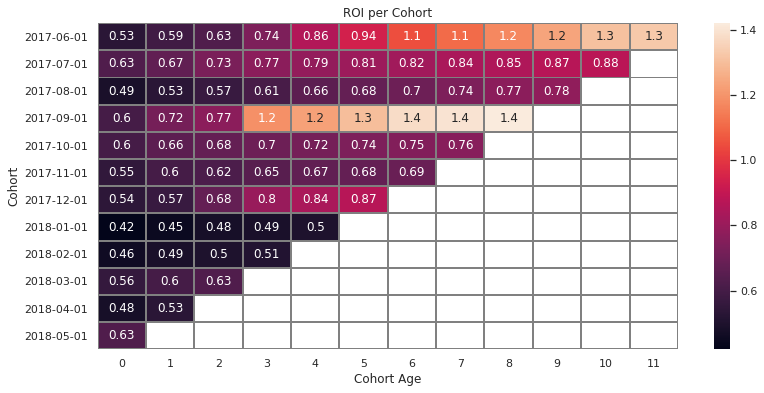

In [91]:
## Create ROI pivot table

roi_pivot = ROI_cohorts.pivot_table(
    index='first_order',
    columns='cohort_age',
    values='roi',
    aggfunc='mean'
).cumsum(axis=1).round(2) 


## Draw a heatmap of LTV

roi_pivot.index = roi_pivot.index.astype(str)
sns.set(style='white')
plt.figure(figsize=(13, 6))
plt.title('ROI per Cohort')
roi_heatmap = sns.heatmap(roi_pivot, annot=True,
           linewidths=1, linecolor='grey');
roi_heatmap.set_xlabel('Cohort Age');
roi_heatmap.set_ylabel('Cohort');

Most cohorts did not pay off, even after 7 to 10 months. June 2017 and September 2017 are the only cohorts that paid off so far. Also, ROI in 2018 is significantly lower, especially over time. 

ROI is increasing over cohort age, so it is likely that given enough time, all cohorts will pay off. However, since 2018 it seems that it will take longer for the cohorts to pay off, as both the original ROI and its increase rate slowed down.


**ROI per Source**

Let's now have a look at ROI per source. We will first need to calculate LTV per source. We already have CAC values.

In [92]:
## Calculate LTV per source

sources_ltv = orders.merge(first_source, on='uid')

sources_ltv_ = sources_ltv.groupby(['source_id']).agg({'uid': 'nunique', 'revenue': 'sum'}).reset_index()
sources_ltv_.columns = ['source_id', 'n_buyers', 'revenue']

sources_ltv_['ltv'] = sources_ltv_['revenue'] / sources_ltv_['n_buyers']


In [93]:
## Merge sources ltv with investment data per source

sources_roi = sources_ltv_.merge(total_investment_by_source, on='source_id')

## Calculate CAC and ROI

sources_roi['cac'] = sources_roi['costs'] / sources_roi['n_buyers']
sources_roi['roi'] = sources_roi['ltv'] / sources_roi['cac']

sources_roi

,source_id,n_buyers,revenue,ltv,costs,cac,roi
0,1,2899,31090.55,10.724577,20833.27,7.186364,1.492351
1,2,3506,46923.61,13.383802,42806.04,12.209367,1.096191
2,3,10473,54511.24,5.204931,141321.63,13.493901,0.385725
3,4,10296,56696.83,5.506685,61073.60,5.931779,0.928336
4,5,6931,52624.02,7.592558,51757.10,7.467479,1.016750
5,9,1088,5759.40,5.293566,5517.49,5.071222,1.043844
6,10,1329,4450.33,3.348631,5822.49,4.381106,0.764335


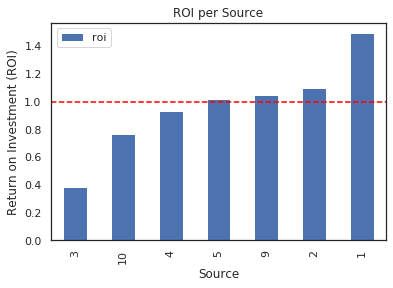

In [94]:
## Plot ROI per source

sources_roi_plot = sources_roi.sort_values(by='roi').plot(kind='bar', x='source_id', y='roi',
                                                         title='ROI per Source')
sources_roi_plot.hlines(1, -1, sources_roi_plot.get_xticks().max()+1,
                          linestyle='--', color='red');
sources_roi_plot.set_xlabel('Source');
sources_roi_plot.set_ylabel('Return on Investment (ROI)');

This graph shows exactly which sources paid off. Source 1 had the highest ROI. Source 2, 9 and 5 had ROI slightly over 1, which means they do pay off not as source 1. The rest of the sources did not return their investment.

##### Conclusions

Looking at ROI by cohorts, we see that most cohorts did not pay off even after 7 months and more. The only cohorts that paid off were June and September 2017. There's a steady increase in ROI over time on all cohorts, so they are likely to pay off eventually.

However, ROI rates were lower in 2018, and their increase rates were also slowing. This means that it would take more time for these cohorts to pay off.

As for the sources, source 1 had the best ROI rates with almost 1.5. Another three sources were paying off: 2, 9 and 5. The rest, however, did not pay off. 

## Conclusions

In this section, conclusions from the analysis will be translated to marketing advices on sources and platform to focus marketing efforts. 

1. **Increase investment in source 1** - My first advice would be to invest more in source 1. Currently, the investment in this source is one of the lowest of all sources (~20,000), while this source has the highest ROI of almost 1.5. In terms of CAC, source 1 is average (CAC=7), but its real benefit comes from the number of orders per user per month. Users from source 1 order more than the rest of the sources (1.5 orders on average). Average purchase size is not the highest among all sources, but is also higher than the average.


2. **Optimize investment in source 2** - Source 2 had a relatively low investment (~40,000). However, average purchase size was much higher than other sources (8), especially during certain periods (December, February and March). Its CAC rates are very high (12), but the users from this source probably place larger orders. Perhaps increasing the investment in this source during the mentioned months would optimize the results.



3. **Reduce investment in source 3** - Source 3 gets the highest investment (140,000), but it doesn't prove itself worthy. It has the lowest ROI (0.4), highest CAC (almost 14), and it is average in terms of average purchase size and orders per month. Overall, this source does not pay off.



4. **Desktops over touch** - Desktops had a slight advantage over touch in all metrics, especially in the average purchase size. The gap grew bigger in winter time - is it could be because more people spent time at home. Perhaps it would be wiser to focus more efforts on desktop users during the winter. It might also be important to make sure that this gap is not caused by a problem in the mobile version.



5. **Retention Rates** - Retention is currently pretty low - only up to 10% of the users keep using the platform in the months after their first session. There are several ways to keep the users coming back: push notifications, emails, special offers, and such measures should be considered.
